In [2]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
filename = "../datasets/baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

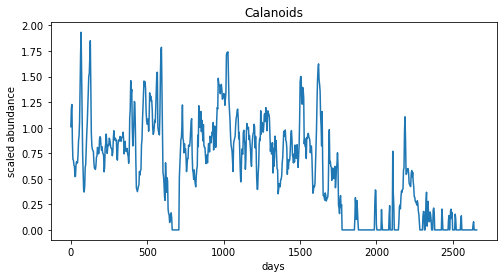

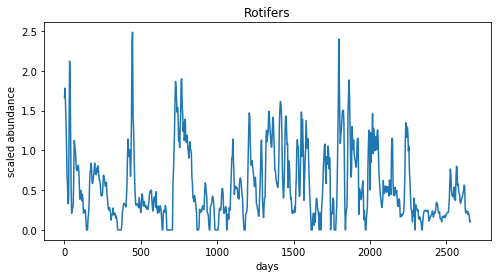

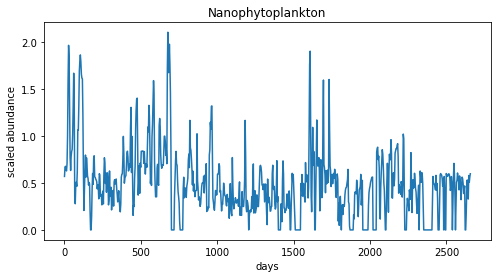

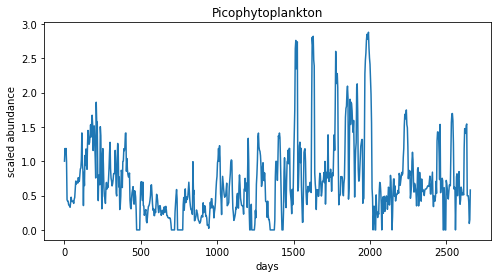

In [4]:
for i in range(4):
    fig, ax = plt.subplots(1,figsize=(8,4))
    ax.set_title(df.columns[i+1])
    ax.plot(table[:,0],table[:,i+1])
    ax.set_ylabel("scaled abundance")
    ax.set_xlabel("days")
    plt.show()

# Tau Determination
To determine the appropriate tau, a balance which maximizes forecast skill while minimizing autocorrelation must be found. We compute the optimal r^2 and autocorrelation for each lag, and find that tau=4 gives the best balance.

In [6]:
E_max = 6
taus = np.arange(1,7)
r_sqrd_table = np.zeros((len(taus),4))

In [8]:
""" uncomment to run for yourself
for i, series in enumerate(table.T[1:]):
    r_sqrds = [ns.get_delta_agg(series, E_max, tau=tau,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:,i] = r_sqrds
    
np.savetxt("../results/baltic_sea_multiwindow/baltic_sea_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")
"""

' uncomment to run for yourself\nfor i, series in enumerate(table.T[1:]):\n    r_sqrds = [ns.get_delta_agg(series, E_max, tau=tau,\n                             return_forecast_skill=True)[2] \n                   for tau in taus]\n    r_sqrd_table[:,i] = r_sqrds\n    \nnp.savetxt("../results/baltic_sea_multiwindow/baltic_sea_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")\n'

In [12]:
# Check Autocorrelation

taus = np.arange(1,7)
autocorr_table = np.zeros((len(taus),4))

for i, series in enumerate(table.T[1:]):
    autocorr_table[:,i] = np.array([np.corrcoef(series[tau:],
                                                series[:-tau])[0,1]
                                  for tau in taus])

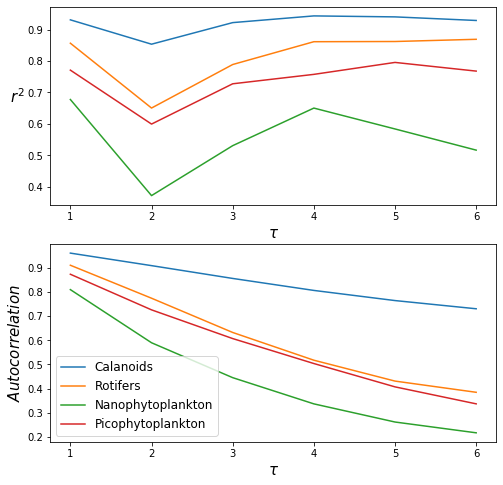

In [13]:
r_sqrd_table = np.loadtxt("../results/baltic_sea_multiwindow/baltic_sea_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(2,figsize=(8,8))
for i in range(4):
    ax[0].plot(taus, r_sqrd_table[:,i], label=df.columns[i+1])
    
for i in range(4):
    ax[1].plot(taus, autocorr_table[:,i], label=df.columns[i+1])

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend(fontsize = 12)

# Effect of Time Window on Baltic Sea Species
Now we systematically evaluate the nonstationarity of subseries of each Baltic Sea series.

In [56]:
year_steps = 27
maxLen = table[:,0].shape[0]
lengths = np.arange(year_steps*4,maxLen+1,step=year_steps)

In [57]:
## Compute delta for each subseries, uncomment if you wish to run again
"""
for i, species in enumerate(df.columns[1:].to_numpy()):
    ts = standardize(table[:,i])
    
    E = 5
    tau = 4
    h = 0

    # length, starting index, delta, theta, r_sqrd
    n_rows = 351
    results = np.zeros((n_rows, 5))
    tally = 0

    for length in lengths:
        for start in np.arange(0, maxLen - length+1, step=year_steps):

            ts_chunk = ts[start:length+start]
            # plotTS(ts_chunk)
            delta, theta, r_sqrd = get_delta_agg(ts_chunk, E-1, tau = tau, 
                                                 return_forecast_skill = True,
                                                 horizon = tau)
            results[tally] = np.array([length, start, delta, theta, r_sqrd])

            tally += 1
            print(tally)
    np.savetxt(f"../results/baltic_sea_multiwindow/{species}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")
"""

'\nfor i, species in enumerate(df.columns[1:].to_numpy()):\n    ts = standardize(table[:,i])\n    \n    E = 5\n    tau = 4\n    h = 0\n\n    # length, starting index, delta, theta, r_sqrd\n    n_rows = 351\n    results = np.zeros((n_rows, 5))\n    tally = 0\n\n    for length in lengths:\n        for start in np.arange(0, maxLen - length+1, step=year_steps):\n\n            ts_chunk = ts[start:length+start]\n            # plotTS(ts_chunk)\n            delta, theta, r_sqrd = get_delta_agg(ts_chunk, E-1, tau = tau, \n                                                 return_forecast_skill = True,\n                                                 horizon = tau)\n            results[tally] = np.array([length, start, delta, theta, r_sqrd])\n\n            tally += 1\n            print(tally)\n    np.savetxt(f"../results/baltic_sea_multiwindow/{species}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")\n'

In [58]:
# Convert the delta values for each subseries into a square matrix
# which is plotted using matplotlib's imshow.
def makeHeatMapBaltic(results):
    nonstationarityHeatMap = np.zeros((29,29)) * np.nan
    for l, o, d, t, r in results:
        i_length = 27-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        # print(i_length, i_offset)
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

In [59]:
# Make the figure
def makeFigureBaltic(nonstationarityHeatMap, ts, name, ax):
    name_to_fig_title = {"Rotifers" : "Figure_S9",
                         "Nanophytoplankton": "Figure_S10",
                         "Picophytoplankton": "Figure_S11"}
    
    scaling = lengths[-1] *3.35 / 365
    
    # im = ax.imshow(np.zeros(nonstationarityHeatMap[:-2].shape), cmap=cm.Greys)
    im = ax.imshow(np.log(nonstationarityHeatMap[:-2]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(31,step = 30 / scaling))
    ax.set_yticks(30-365*np.arange(1,8)/3.35/26)
    ax.set_xticklabels([])
    ax.set_yticklabels(np.arange(1,8))
    ax.set_ylim(27,-1)
    ax.set_xlim(-1.3,32)
    
    ax.set_ylabel("Time series length (years)",fontsize=15)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(table[:,0]/365, ts,c="dodgerblue")
    axTS.set_ylabel(name,fontsize=12)
    axTS.set_xlabel("Start year",fontsize=15)
    axTS.set_yticks([])
    
    plt.savefig(f"../figures_eps/baltic_sea_multiwindow/{name_to_fig_title[name]}.eps", format="eps", bbox_inches="tight", transparent=False, facecolor="white")
    plt.show()

In [60]:
# Make a custom orange to blue color scheme
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 
custom_cmap.set_bad("white", 1)

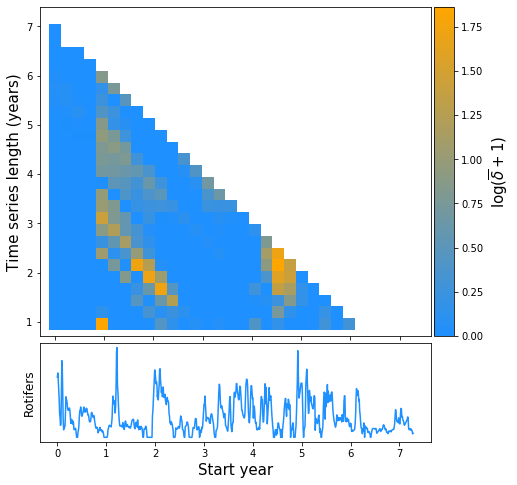

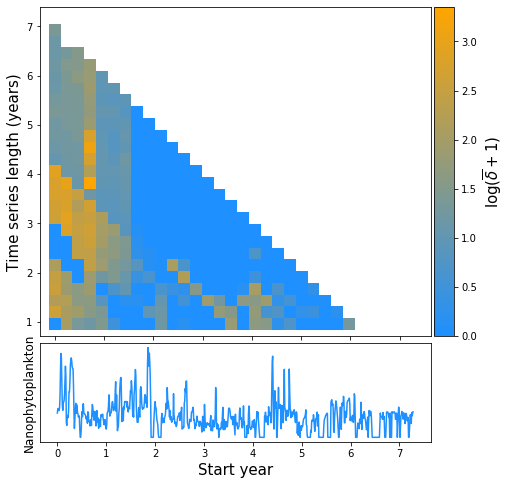

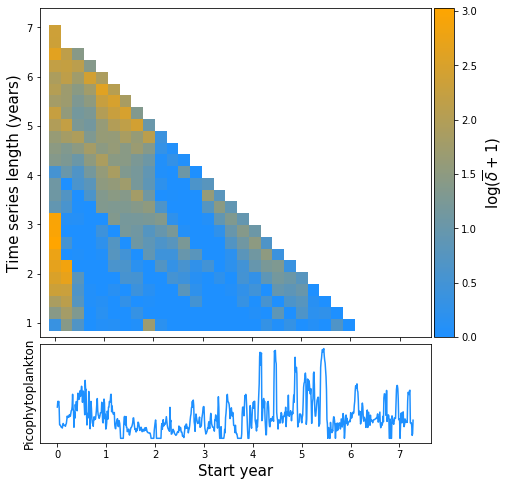

In [61]:
# Produce the figures
indices = [1,2,3]
year_steps = 27

for index in indices:
    figb, axb = plt.subplots(1, figsize=(8,8))
    
    species_list = ["Calanoids","Rotifers","Nanophytoplankton",
                    "Picophytoplankton"]
    results = np.loadtxt(f"../results/baltic_sea_multiwindow/{species_list[index]}_time_window.csv",
                         delimiter=",")
    lengths = np.unique(results[:,0])
    
    ts = ns.standardize(table[:,index+1])
    nonstationarityHeatMap = makeHeatMapBaltic(results)
    makeFigureBaltic(nonstationarityHeatMap, ts, species_list[index], axb)